# U-NET + ResNet34 Model trained on imagenet dataset as backbone

[ResNet35](https://arxiv.org/abs/1512.03385)

[UNET](https://arxiv.org/abs/1505.04597)

In [ ]:
!pip install -q segmentation_models 
!pip install -q numpy==1.19.5

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model
import os
import cv2
import glob
import random
from PIL import Image
import numpy as np
import segmentation_models as sm
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical 
from keras.utils.np_utils import normalize
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [3]:
HEIGHT = 128 
WIDTH = 128
n_classes=9
path = '/content/drive/MyDrive/ScaleDataNEW/'
image_dir = path
mask_dir = path

In [ ]:
#image
image_dataset = []
for path, subdirs, files in os.walk(image_dir): 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'Original':  
        image = os.listdir(path) 
        image.sort()
        for i, image_name in enumerate(image):
          if image_name.endswith(".jpg"):
            mask = cv2.imread(path+"/"+image_name, 1)
            mask = cv2.resize(mask, (HEIGHT, WIDTH), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
            image_dataset.append(mask)
train_image  = np.array(image_dataset)

In [ ]:
mask_dataset = []  
for path, subdirs, files in os.walk(mask_dir): 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'Mask':  
        masks = os.listdir(path) 
        masks.sort()
        for i, mask_name in enumerate(masks):
          if mask_name.endswith(".jpg"):
            mask = cv2.imread(path+"/"+mask_name, 0)
            mask = cv2.resize(mask, (HEIGHT, WIDTH), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
            mask_dataset.append(mask)
train_masks  = np.array(mask_dataset)

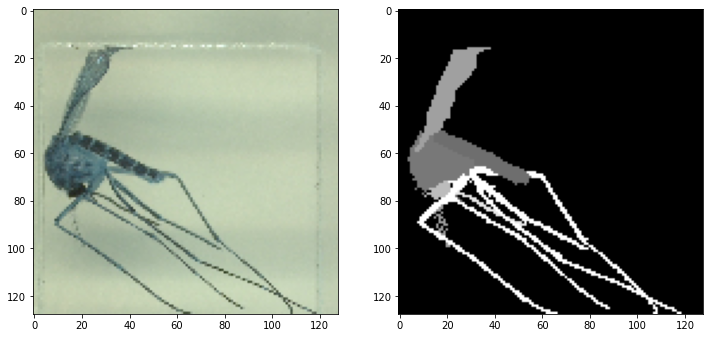

In [6]:
image_number = random.randint(0, len(train_image)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_image[image_number,:,:,:])
plt.subplot(122)
plt.imshow(train_masks[image_number,:,:], cmap='gray')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

In [8]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_image, train_masks_input, test_size = 0.20, random_state = 10)

In [9]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [10]:
n_classes=9
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [11]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [12]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape = (128,128,3), classes=n_classes, activation=activation)
# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)


print(model1.summary())

85532672/85521592 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=500,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

In [14]:
y_predict1 = model1.predict(X_test1)
y_predict1_argmax = np.argmax(y_predict1,axis=3)

In [24]:
from keras.metrics import MeanIoU
n_classes = 9
IoU_keras = MeanIoU(num_classes = n_classes)

IoU_keras.update_state(y_test[:,:,:,0],y_predict1_argmax)

print("MEAN IoU = ", IoU_keras.result().numpy())

MEAN IoU =  0.9256459951400757


In [16]:
y_pred=model1.predict(X_test1)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
y_train_cat_argmax = np.argmax(y_train_cat, axis=3)

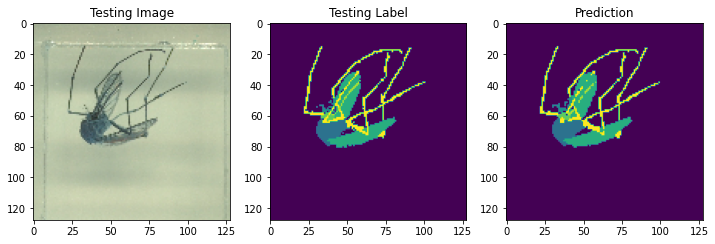

In [18]:
import random
test_img_number = random.randint(0, len(X_train1))
test_img = X_train1[test_img_number]
ground_truth=y_train_cat_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model1.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_img)
plt.show()